In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

### Enkodovanje labela

In [2]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = to_categorical(labels_encoded)
    
    return labels_encoded

### Konvertovanje u grayscale

In [8]:
def convevrt_to_graysccale(training_data):
    traininf_data_gray = []
    for img in training_data:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        traininf_data_gray.append(img)
    traininf_data_gray = np.array(traininf_data_gray)
    np.save('data_gray.npy', traininf_data_gray)

### Resizing slika

In [7]:
def resize_images(training_data_gray):
    training_data_resized = []
    for img in training_data_gray:
        img = cv2.resize(img, (28, 28))
        training_data_resized.append(img)
    training_data_resized = np.array(training_data_resized)
    np.save('data_resized.npy', training_data_resized)

### Ucitavanje i priprema podataka

In [3]:
training_data = np.load('data_resized.npy', allow_pickle=True)
training_labels = np.load('labels.npy', allow_pickle=True)

In [4]:
lbls = encode_labels(training_labels)

In [5]:
data = []

for i in range(len(training_data)): 
    data.append([training_data[i], lbls[i]])

### Kreiranje dataseta i tensora

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]

        if self.transform:
            image = self.transform(image)

        return image, label

    def transform(self, image):
        return ToTensor()(image)

    def plot(self, idx):
        image, label = self.__getitem__(idx)
        image = image.permute(1, 2, 0)
        plt.imshow(image, cmap='gray')
        plt.title(label)
        plt.show()

In [7]:
class ToTensor(object):
    def __call__(self, image):
        image = np.expand_dims(image, axis=0)
        return torch.from_numpy(image)

In [8]:
data_ready = []
for i in range(len(data)):
    data_ready.append([data[i][0].astype(np.float32), data[i][1]])

c:\Users\Zephyrus\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


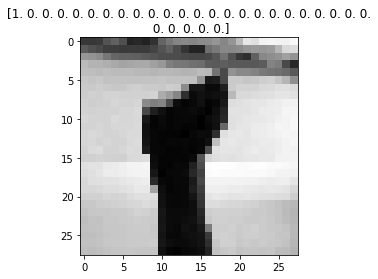

In [9]:
custom_dataset = CustomDataset(data_ready, transform=ToTensor())

# prikaz sampla iz dataseta
custom_dataset.plot(0)

In [10]:
labels_map = {}
for i, label in enumerate(training_labels):
    if label not in labels_map:
        labels_map[i] = label

Prikaz primera podataka iz razlicitih klasa

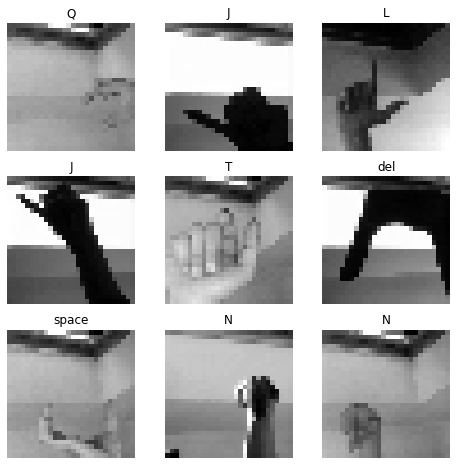

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx], training_labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Podela podataka na train/val/test setove

In [55]:
train_val_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_val_size

train_val_data, test_dataset = torch.utils.data.random_split(custom_dataset, [train_val_size, test_size])

In [56]:
train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_data, [train_size, val_size])

In [57]:
#prikaz sampla iz train_dataseta
train_dataset.dataset[0]

(tensor([[[138., 134., 126., 130., 143., 144., 149., 145., 144., 143., 140.,
           139., 135., 120., 113., 113., 103.,  99.,  95.,  88.,  81.,  82.,
            89.,  72.,  60.,  54.,  40.,  53.],
          [201., 200., 198., 197., 193., 184., 174., 163., 149., 139., 126.,
           118., 125., 146., 147., 147., 146., 143., 141., 135., 123., 114.,
           110., 107., 100.,  91.,  82.,  70.],
          [203., 199., 199., 198., 197., 197., 198., 198., 198., 200., 199.,
           196., 192., 192., 184., 165., 150., 140., 127., 116., 126., 146.,
           150., 148., 147., 142., 134., 119.],
          [205., 205., 205., 205., 204., 204., 205., 209., 221., 252., 212.,
           241., 200., 196., 195., 195., 195., 193., 192., 190., 189., 188.,
           180., 166., 151., 136., 128., 116.],
          [204., 204., 205., 206., 205., 206., 210., 252., 251., 251., 252.,
           251., 193., 200., 199., 199., 199., 198., 196., 193., 193., 191.,
           192., 190., 190., 189., 191

### Kreiranje dataloadera

In [58]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32, 29])


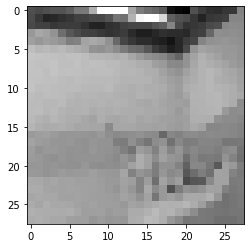

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [59]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Mreza i  treniranje

In [60]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 29)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [62]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cpu


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=29, bias=True)
)

Epoch 1
Loss: 0.05211990903741841, Val Loss: 0.016083763970126366
Acc: 0.5038972701149426, Val Acc: 0.8441091954022989
---------------------------------------------------
Epoch 2
Loss: 0.023008119478425675, Val Loss: 0.007215843061734548
Acc: 0.7467852011494253, Val Acc: 0.9298132183908046
---------------------------------------------------
Epoch 3
Loss: 0.017748183281503446, Val Loss: 0.005749996353727605
Acc: 0.8070222701149425, Val Acc: 0.9438936781609195
---------------------------------------------------
Epoch 4
Loss: 0.015471851939453218, Val Loss: 0.004463450189133913
Acc: 0.832489224137931, Val Acc: 0.957471264367816
---------------------------------------------------
Epoch 5
Loss: 0.013627614760129102, Val Loss: 0.004128653242656876
Acc: 0.8539870689655172, Val Acc: 0.9579741379310345
---------------------------------------------------
Epoch 6
Loss: 0.01292223004716577, Val Loss: 0.0033027635418927705
Acc: 0.8648347701149425, Val Acc: 0.9698275862068966
-----------------------

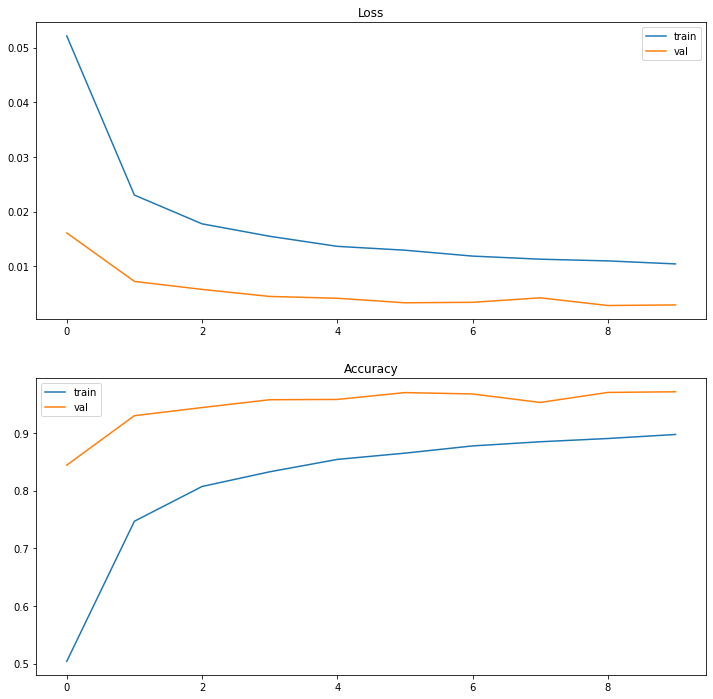

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
loss_tr, loss_val = [], []
acc_tr, acc_val = [], []

for epoch in range(10):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    loss_tr.append(running_loss / total)
    acc_tr.append(correct / total)

    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    loss_val.append(running_loss / total)
    acc_val.append(correct / total)

    print(f"Epoch {epoch+1}")
    print(f"Loss: {loss_tr[-1]}, Val Loss: {loss_val[-1]}")
    print(f"Acc: {acc_tr[-1]}, Val Acc: {acc_val[-1]}")
    print("---------------------------------------------------")

ax[0].plot(loss_tr, label='train')
ax[0].plot(loss_val, label='val')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(acc_tr, label='train')
ax[1].plot(acc_val, label='val')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [64]:
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(torch.max(labels, 1)[1].cpu().numpy())

In [65]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = np.sum(y_true == y_pred)/len(y_true)
print(f"Test accuracy:{acc}")

Test accuracy:0.9710919540229885


In [66]:
klase = list(set(labels_map.values()))
klase

['M',
 'T',
 'B',
 'R',
 'W',
 'G',
 'C',
 'V',
 'Q',
 'J',
 'N',
 'O',
 'L',
 'E',
 'I',
 'D',
 'K',
 'X',
 'Y',
 'P',
 'H',
 'U',
 'del',
 'S',
 'A',
 'F',
 'nothing',
 'Z',
 'space']

Tacnost svake pojedinacne klase i broj uzoraka iz nje

In [67]:
acc_clas = np.zeros(29)
num_samples = np.zeros(29)
for i in range(29):
    idx = np.where(y_true == i)
    acc_clas[i] = np.sum(y_true[idx] == y_pred[idx]) / len(y_true[idx])
    num_samples[i] = len(y_true[idx])
    print(f"Class {klase[i]}: {acc_clas[i]}, samples: {num_samples[i]}")

Class M: 0.9771615008156607, samples: 613.0
Class T: 0.9835526315789473, samples: 608.0
Class B: 0.9964850615114236, samples: 569.0
Class R: 0.9966499162479062, samples: 597.0
Class W: 0.8888888888888888, samples: 621.0
Class G: 0.9949238578680203, samples: 591.0
Class C: 0.9950738916256158, samples: 609.0
Class V: 0.9857142857142858, samples: 630.0
Class Q: 0.9825949367088608, samples: 632.0
Class J: 0.9947916666666666, samples: 576.0
Class N: 0.9967159277504105, samples: 609.0
Class O: 0.99644128113879, samples: 562.0
Class L: 0.9694793536804309, samples: 557.0
Class E: 0.9480968858131488, samples: 578.0
Class I: 0.983633387888707, samples: 611.0
Class D: 0.979933110367893, samples: 598.0
Class K: 0.9982993197278912, samples: 588.0
Class X: 0.9674657534246576, samples: 584.0
Class Y: 0.9512195121951219, samples: 615.0
Class P: 0.9790209790209791, samples: 572.0
Class H: 0.8811188811188811, samples: 572.0
Class U: 0.9044481054365733, samples: 607.0
Class del: 0.9128367670364501, sampl

Matrica konfuzije

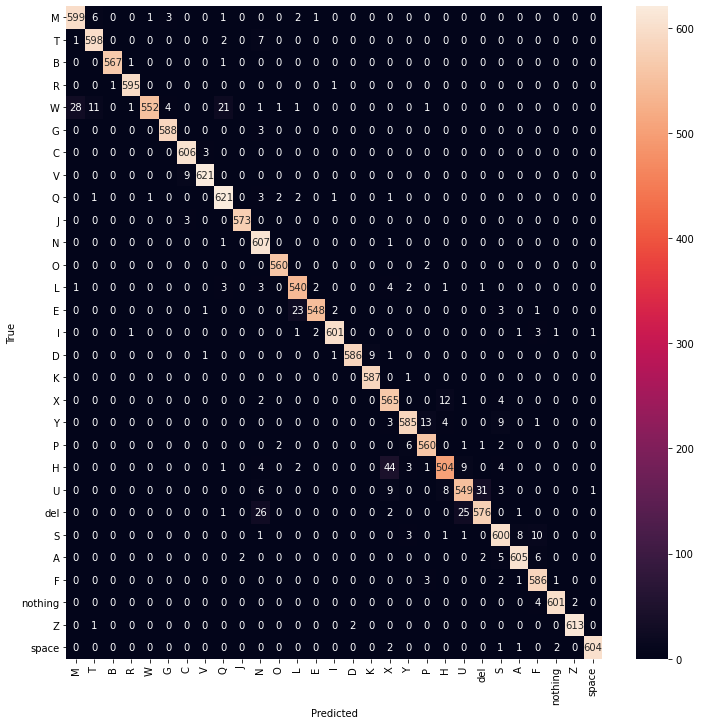

In [68]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=klase, yticklabels=klase)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [69]:
torch.save(net.state_dict(), 'model.pth')